# Model g

In [1]:
import os
from collections import deque

import numpy as np
import torch
from tensorboardX import SummaryWriter
from unityagents import UnityEnvironment

from maddpg import MADDPG
from buffer import ReplayBuffer
from support import tensorfy

import matplotlib.pyplot as plt

# Settings

In [8]:
# ##############################################################################
#                                                  SETTINGS
# ##############################################################################
MODEL_NAME = "model_g"
# ENV_FILE = "Tennis_Linux/Tennis.x86_64"
ENV_FILE = "Tennis_Linux_NoVis/Tennis.x86_64"

#ACTOR_LAYER_SIZES =  [24, 256,128,2]
#CRITIC_LAYER_SIZES = [52, 256,128,1]
ACTOR_LAYER_SIZES =  [12, 256,128,2]
CRITIC_LAYER_SIZES = [22, 256,128,1]

SEED = 777
TAU = 0.02
CLAMP_ACTIONS=True
GRADIENT_CLIPPING = None  # Amount to clip gradients by

# Amplitude of OU Noise - used for random exploration
# - decayed over time
noise = 2.0
HARD_NOISE_STEPS = 500
NOISE_DECAY = 0.995
DO_RANDOM_SWAP = False

DISCOUNT_FACTOR = 0.95    # For discounted rewards
LR_ACTOR = 1e-3         # Learning rate for actor networks
LR_CRITIC = 1e-3        # Learning rate for critic networks

EPISODES_PER_UPDATE = 1   # How often to update the network
N_BATCHES_PER_UPDATE = 4  # How many batches of samples to take when updating
UPDATE_TARGET_AFTER_EACH_BATCH = False # Update after every batch? or after end of update cluster

BATCH_SIZE = 1024         # How many samples to take from buffer with each update
BUFFER_SIZE = 100000     # Max size of experience replay buffer
MIN_BUFFER_SIZE = 1 * HARD_NOISE_STEPS # how many experiences should be in buffer before starting to train
MIN_BUFFER_SIZE = BATCH_SIZE * N_BATCHES_PER_UPDATE # how many experiences should be in buffer before starting to train


N_AGENTS = 2              # Number of agents in environment
N_ACTIONS = 2             # Number of actions the agent can take
MAX_STEPS = 1000        # max number of steps for an episode
SOLVED_SCORE = 0.5      # Score needed to be considered solved
SOLVED_WINDOW = 100     # Rolling average window size used to evaluate solved score

In [9]:
# ##############################################################################
#                                                  SUPPORT
# ##############################################################################
def process_agent_states(states):
    """ Given an array of shape [n_agents, state_size], it
        Only keeps a subset of the state information for each agent """
    # states = scale_agent_state(states)
    return states[:,[3,4,5,11,12,13,16,17,18,19,20,21]]
    #return states
    # return states[:,:]

def process_gobal_state(states):
    """ Given an array of shape [n_agents, state_size], it
        Only keeps a subset of the state information for each agent
        that is not duplicate, or redundant.
        returns an array of shape [18]
    """
    # states = scale_agent_state(states)
    #a = states[0,:]
    #b = states[1,:]
    a = states[0,[3,11,16,17,18,19]]
    b = states[1,[3,4,5,11,12,13,16,17,18,19,20,21]]
    c = np.concatenate([a,b])
    return c

In [4]:
# ##############################################################################
#                                                  SETUP
# ##############################################################################
# Generate Output Directory Paths
model_dir = os.path.join("models", MODEL_NAME)
tensorboard_dir = os.path.join(model_dir, "tensorboard")
snapshots_dir = os.path.join(model_dir, "snapshots")
os.makedirs(model_dir, exist_ok=True)
os.makedirs(tensorboard_dir, exist_ok=True)
os.makedirs(snapshots_dir, exist_ok=True)

# SET SEEDS FOR REPRODUCIBILITY
np.random.seed(SEED)
torch.manual_seed(SEED)

# TENSORBOARD
logger = SummaryWriter(log_dir=tensorboard_dir)

In [5]:
# ##############################################################################
#                                                  ENVIRONMENT
# ##############################################################################
env = UnityEnvironment(file_name=ENV_FILE, seed=SEED)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
action_size = brain.vector_action_space_size
action_type = brain.vector_action_space_type

states = env_info.vector_observations
#state_size = brain.vector_observation_space_size # gives wrong value for this environment
state_size = states.shape[1]
state_type = brain.vector_observation_space_type

print("{dec}\nENVIRONMENT\n{dec}".format(dec="="*60))
print('Number of agents               :', num_agents)
print('Action Shape                   :', action_size)
print("Action Type                    :", action_type)
print("State Shape (all agents)       :", states.shape)
print("State Shape (individual agent) :", state_size)
print("State Type                     :", state_type)
print('\nExample state for a single agent:\n', states[0])

agent_state_size = process_agent_states(states).shape[1]
global_state_size = process_gobal_state(states).shape[0]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


ENVIRONMENT
Number of agents               : 2
Action Shape                   : 2
Action Type                    : continuous
State Shape (all agents)       : (2, 24)
State Shape (individual agent) : 24
State Type                     : continuous

Example state for a single agent:
 [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.85842943 -1.5        -0.          0.
  6.44118643  6.         -0.          0.        ]


In [13]:
# ##############################################################################
#                                                  AGENT
# ##############################################################################
# Create Multi agent Actor-Critic Model
maddpg = MADDPG(actor_layer_sizes=ACTOR_LAYER_SIZES,
                critic_layer_sizes=CRITIC_LAYER_SIZES,
                discount_factor=DISCOUNT_FACTOR,
                tau=TAU,
                lr_actor=LR_ACTOR,
                lr_critic=LR_CRITIC,
                gradient_clipping=GRADIENT_CLIPPING,
                clamp_actions=CLAMP_ACTIONS,
                logger=logger,
                log_losses=True,
                log_layers=False,
                log_weights=False,
                )

In [14]:
# ##############################################################################
#                                                  TRAIN
# ##############################################################################
buffer = ReplayBuffer(int(BUFFER_SIZE), seed=SEED)

n_episodes = 10000
best_rolling_mean_score = -np.inf
hard_noise_reigime = True
solved = False
rewards_deque = deque(maxlen=SOLVED_WINDOW)
history = []
history_rolling_mean = []

# episode_i = 0
for episode_i in range(1, n_episodes+1):
    # INITIALIZE FOR NEW EPISODE
    rewards_this_episode = np.zeros((N_AGENTS,))
    env_info = env.reset(train_mode=True)[brain_name]
    states = process_agent_states(env_info.vector_observations)
    global_state = process_gobal_state(env_info.vector_observations)

    # COLLECT A FULL EPISODE OF EXPERIENCES
    for step in range(MAX_STEPS):
        maddpg.reset_ounoise()

        # GET ACTIONS TO TAK ADN INTERACT WITH THE ENVIRONMENT
        actions = maddpg.act(tensorfy(states), noise=noise, stacked=True)
        env_info = env.step(actions)[brain_name]

        # EXTRACT AND PROCESS THE RETRUNED VALUES FROM ENVIRONMENT
        next_states = process_agent_states(env_info.vector_observations)
        next_global_state = process_gobal_state(env_info.vector_observations)
        rewards = env_info.rewards
        dones = env_info.local_done

        # ADD EXPERIENCE TO THE BUFFER
        experience = (states, global_state, actions, rewards, next_states, next_global_state, dones)
        buffer.push(experience)

        # UPDATE REWARDS
        rewards_this_episode += rewards

        # PREPARE FOR NEXT TIMESTEP
        states = next_states
        global_state = next_global_state
        noise = noise if hard_noise_reigime else noise*NOISE_DECAY

        # END EPISODE IF ANY AGENT IS DONE
        if any(dones):
            break

    if episode_i > HARD_NOISE_STEPS:
        hard_noise_reigime = False

    # POTENTIALLY START TAKING SAMPLES TO TRAIN FROM EXPERIENCE BUFFER
    if len(buffer) > MIN_BUFFER_SIZE:
        update_flag = "u"
        for _ in range(N_BATCHES_PER_UPDATE):
            for agent_i in range(N_AGENTS):
                # samples = buffer.sample(3)
                samples = buffer.sample(BATCH_SIZE)
                maddpg.update(samples, agent_i)
                if UPDATE_TARGET_AFTER_EACH_BATCH:
                    maddpg.update_targets()
            if not UPDATE_TARGET_AFTER_EACH_BATCH:
                maddpg.update_targets()
    else:
        update_flag = " "

    # UPDATE EPISODE AND ROLLING MEAN SCORES
    agg_reward_this_episode = np.max(rewards_this_episode)
    rewards_deque.append(agg_reward_this_episode)
    rolling_mean_reward = np.mean(rewards_deque)

    history.append(agg_reward_this_episode)
    history_rolling_mean.append(rolling_mean_reward)

    # MONITOR PROGRESS IN TENSORBOARD
    if logger is not None:
        logger.add_scalars('rewards/Rewards_this_episode',
                       {'Agent_0': rewards_this_episode[0],
                        'Agent_1': rewards_this_episode[1]},
                       episode_i)
        logger.add_scalars('rewards/Aggregated_Rewards_Over_Time',
                       {'Rolling mean reward': rolling_mean_reward,
                        'Reward this episode (max agent)': agg_reward_this_episode},
                       episode_i)
        logger.add_scalars('actions/Actions_Agent_0',
                       {'Action_0': actions[0][0],
                        'Action_1': actions[0][1]},
                       episode_i)
        logger.add_scalars('actions/Actions_Agent_1',
                       {'Action_0': actions[1][0],
                        'Action_1': actions[1][1]},
                       episode_i)
        logger.add_scalars('noise/noise', {"noise": noise}, episode_i)
        logger.add_scalars('steps/episode_steps', {"steps": step}, episode_i)

    # CHECK IF IT IS A NEW BEST MODEL - And take a snapshot of best so far
    if rolling_mean_reward > best_rolling_mean_score:
        best_rolling_mean_score = rolling_mean_reward
        maddpg.save_model(os.path.join(snapshots_dir, 'best_model.snapshot'))
        feedback_postfix = "*(new best)\n"
    else:
        feedback_postfix = " "

    # FEEDBACK PRINTOUT
    feedback = "\r{ep: 5d} Reward: {rw: 3.3f} Rolling Mean Reward: {rm: 3.3f} {uf} {ps}"
    feedback = feedback.format(ep=episode_i, rm=rolling_mean_reward, rw=agg_reward_this_episode, uf=update_flag, ps=feedback_postfix)
    print(feedback, end="")

    # CHECK IF SOLVED
    if (rolling_mean_reward >= SOLVED_SCORE) and not solved:
        solved = True
        maddpg.save_model(os.path.join(snapshots_dir, 'solved_model_{:05d}.snapshot'.format(episode_i)))
        print("\nSolved in {}-100 steps".format(episode_i))
        print("- with an average score of {}".format(rolling_mean_reward))
        print("- snapshot of model taken")
        print("- but continuing to train further ... \n")

    1 Reward:  0.000 Rolling Mean Reward:  0.000   *(new best)
    4 Reward:  0.090 Rolling Mean Reward:  0.023   *(new best)
   16 Reward:  0.100 Rolling Mean Reward:  0.024   *(new best)
   18 Reward:  0.090 Rolling Mean Reward:  0.026   *(new best)
   19 Reward:  0.090 Rolling Mean Reward:  0.029   *(new best)
  475 Reward:  0.090 Rolling Mean Reward:  0.030 u *(new best)
  479 Reward:  0.090 Rolling Mean Reward:  0.031 u *(new best)
  480 Reward:  0.090 Rolling Mean Reward:  0.032 u *(new best)
  489 Reward:  0.090 Rolling Mean Reward:  0.033 u *(new best)
  490 Reward:  0.090 Rolling Mean Reward:  0.034 u *(new best)
  491 Reward:  0.090 Rolling Mean Reward:  0.035 u *(new best)
  493 Reward:  0.090 Rolling Mean Reward:  0.035 u *(new best)
  494 Reward:  0.090 Rolling Mean Reward:  0.036 u *(new best)
  497 Reward:  0.100 Rolling Mean Reward:  0.037 u *(new best)
  498 Reward:  0.090 Rolling Mean Reward:  0.038 u *(new best)
  499 Reward:  0.090 Rolling Mean Reward:  0.039 u *(ne

 4554 Reward:  1.400 Rolling Mean Reward:  2.017 u *(new best)
 4558 Reward:  2.700 Rolling Mean Reward:  2.029 u *(new best)
 4559 Reward:  2.600 Rolling Mean Reward:  2.045 u *(new best)
 4562 Reward:  2.600 Rolling Mean Reward:  2.047 u *(new best)
 4563 Reward:  0.300 Rolling Mean Reward:  2.049 u *(new best)
 4577 Reward:  2.600 Rolling Mean Reward:  2.067 u *(new best)
 4581 Reward:  2.700 Rolling Mean Reward:  2.092 u *(new best)
 4587 Reward:  2.600 Rolling Mean Reward:  2.116 u *(new best)
 4588 Reward:  0.200 Rolling Mean Reward:  2.117 u *(new best)
 4590 Reward:  2.700 Rolling Mean Reward:  2.118 u *(new best)
 4645 Reward:  2.700 Rolling Mean Reward:  2.119 u *(new best)
 4647 Reward:  2.600 Rolling Mean Reward:  2.139 u *(new best)
 4650 Reward:  2.600 Rolling Mean Reward:  2.164 u *(new best)
 4651 Reward:  2.700 Rolling Mean Reward:  2.165 u *(new best)
 4652 Reward:  0.100 Rolling Mean Reward:  2.166 u *(new best)
 4654 Reward:  2.600 Rolling Mean Reward:  2.178 u *(ne

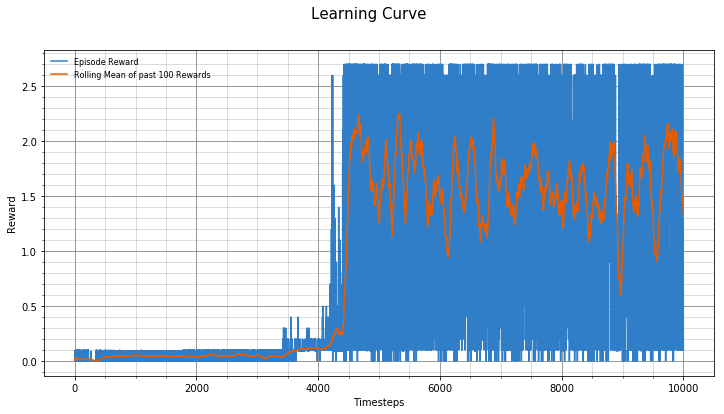

In [16]:
# ##############################################################################
#                            PLOT OF TRAINING CURVES
# ##############################################################################
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle("Learning Curve", fontsize=15)
ax.plot(history, color="#307EC7", label="Episode Reward")
ax.plot(history_rolling_mean, color="#E65C00", label="Rolling Mean of past {} Rewards".format(SOLVED_WINDOW))
ax.set_xlabel("Timesteps")
ax.set_ylabel("Reward")
# GRID
ax.grid(True)
ax.grid(b=True, which='major', color='#999999', linestyle='-', linewidth=1)
ax.minorticks_on()
ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.7, linewidth=0.5)
# LEGEND
ax.legend(loc="upper left", title="", frameon=False,  fontsize=8)
fig.savefig(os.path.join(model_dir, "learning_curve.jpg"))

In [21]:
best_snapshot_step = np.argwhere(np.array(history_rolling_mean) == best_rolling_mean_score)[0]
template = "Best snapshot taken at a rolling average of {v} at timestep {t}"
print(template.format(v=best_rolling_mean_score, t=best_snapshot_step+1))

Best snapshot taken at a rolling average of 2.2529000335745515 at timestep [5311]


In [ ]:
env.close()
logger.close()